# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [2]:
#https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import normalize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages = 3 

2022-03-06 12:38:31.915233: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 12:38:31.915264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'CNN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 


In [5]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

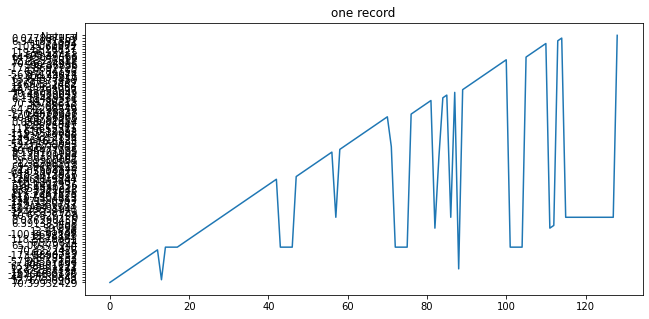

In [11]:
y = traffic_df.iloc[[0]].values.tolist() 
x = list(range(0, len(y[0])))
fig = plt.figure(figsize=(10,5))
plt.plot(x,y[0])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.title('one record')
plt.show()

In [37]:
traffic_df.columns

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)

In [38]:
# Delete marker column 
traffic_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [39]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 128)
combine shape (78377, 128)
attack shape (55663, 128)


In [40]:
# This is how it looks
traffic_np
print(traffic_np.shape)

(22714, 128)


In [41]:
# manage NaNs & inf
print('normal traffic NaNs', np.count_nonzero(np.isnan(traffic_np)))
print('normal traffic inf', np.count_nonzero(np.isinf(traffic_np)))
print('combine traffic NaNs', np.count_nonzero(np.isnan(combine_np)))
print('combine traffic inf', np.count_nonzero(np.isinf(combine_np)))
print('attack traffic NaNs', np.count_nonzero(np.isnan(attack_np)))
print('attack traffic inf', np.count_nonzero(np.isinf(attack_np)))
traffic_np = np.nan_to_num(traffic_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
combine_np = np.nan_to_num(combine_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
attack_np = np.nan_to_num(attack_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# not so sure that inf is correctly set to 0

normal traffic NaNs 0
normal traffic inf 3753
combine traffic NaNs 0
combine traffic inf 10906
attack traffic NaNs 0
attack traffic inf 7153


In [42]:
# normalize the data on each column

traffic_np_norm = normalize(traffic_np, axis=0, norm='max')
combine_np_norm = normalize(combine_np, axis=0, norm='max')
attack_np_norm = normalize(attack_np, axis=0, norm='max')

# alternative normalization
from sklearn.preprocessing import minmax_scale
traffic_np_norm = minmax_scale(traffic_np, feature_range=(0, 1), axis=0, copy=True)
combine_np_norm = minmax_scale(combine_np, feature_range=(0, 1), axis=0, copy=True)
attack_np_norm = minmax_scale(attack_np, feature_range=(0, 1), axis=0, copy=True)

#adding noise to x_train
noise = np.random.normal(0, NOISE, traffic_np_norm.shape)

In [43]:
x_train = traffic_np_norm[...,np.newaxis]
x_combine = combine_np_norm[...,np.newaxis]
x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", x_train.shape)
print("Combine Traffic Test input shape: ", x_combine.shape)
print("Attack Traffic Test input shape: ", x_attack.shape)

Normal Traffic Training input shape:  (22714, 128, 1)
Combine Traffic Test input shape:  (78377, 128, 1)
Attack Traffic Test input shape:  (55663, 128, 1)


In [44]:
x_train.shape

(22714, 128, 1)

In [47]:
input_dim = x_train.shape[1]
encoding_dim = x_train.shape[1]

def build_model_ANN():
   input_ANN = layers.Input(shape=(input_dim, ))
#   encoder = layers.Dropout(rate=0.2)(input_ANN)
   encoder = layers.Dense(4096, activation='relu')(input_ANN)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(1024, activation='relu')(input_ANN)
   encoder = layers.Dense(512, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(128, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(32, activation='relu')(encoder)
   decoder = layers.Dropout(rate=0.2)(encoder)
   decoder = layers.Dense(128, activation='relu')(decoder)
   decoder = layers.Dropout(rate=0.2)(decoder)
   decoder = layers.Dense(512, activation='tanh')(decoder)
   decoder = layers.Dense(1024, activation='tanh')(decoder)
   decoder = layers.Dense(4096, activation='tanh')(decoder)
   out_layer = layers.Dense(encoding_dim, activation = 'tanh')(decoder)
   autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)
   return autoencoder

def build_model_CNN():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

In [53]:
# We arange dimensions to work with CNN or ANN
# Remember CNN has an additional dimension at the end

keras.backend.clear_session()

if NETWORK == 'CNN':
    model = build_model_CNN()
    noise = noise[...,np.newaxis]
elif NETWORK == 'ANN':
    model == build_model_ANN()
    x_train = np.squeeze(x_train)
    x_attack = np.squeeze(x_attack)
    x_combine = np.squeeze(x_combinex)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 64, 512)           4096      
                                                                 
 dropout (Dropout)           (None, 64, 512)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 256)           393472    
                                                                 
 dropout_1 (Dropout)         (None, 32, 256)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 64)            49216     
                                                                 
 dropout_2 (Dropout)         (None, 16, 64)            0     

In [54]:
noise.shape

(22714, 128, 1)

In [55]:
## Train the model

#Note that we are using `x_train` as both the input and the target
#since this is a reconstruction model.
#"""
x_train_noisy = x_train + noise

history = model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.17,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
148/148 [==============================] - 80s 537ms/step - loss: 0.0507 - val_loss: 0.0159
Epoch 2/50
148/148 [==============================] - 86s 581ms/step - loss: 0.0156 - val_loss: 0.0085
Epoch 3/50
148/148 [==============================] - 74s 499ms/step - loss: 0.0104 - val_loss: 0.0083
Epoch 4/50
148/148 [==============================] - 66s 447ms/step - loss: 0.0084 - val_loss: 0.0071
Epoch 5/50
148/148 [==============================] - 68s 458ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 6/50
148/148 [==============================] - 72s 485ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 7/50
148/148 [==============================] - 73s 491ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 8/50
148/148 [==============================] - 73s 495ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/50
148/148 [==============================] - 69s 465ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 10/50
148/148 [==============================] - 68s 462ms/step - l

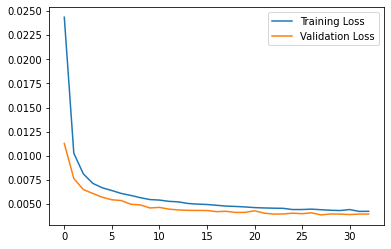

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [56]:
### Test the results
## use combine_labels as ground truth

# Get test attack loss.
x_attack_pred = model.predict(x_attack)
attack_mae_loss = np.mean(np.abs(x_attack_pred - x_attack), axis=1)
attack_mae_loss = attack_mae_loss.reshape((-1))

# Get test MAE loss.
x_test_pred = model.predict(x_combine)
test_mae_loss = np.mean(np.abs(x_test_pred - x_combine), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss = train_mae_loss.reshape((-1))

threshold_calc = np.max(train_mae_loss)
print('calculated threshold',threshold_calc)

# alternative threshold calculation
max = np.max(train_mae_loss)
min = np.min(train_mae_loss)
threshold_alt = (max-min)/2

print('alternative threshold',threshold_alt)

threshold = threshold_calc
threshold = 0.05
threshold = threshold_alt

if THRESHOLD == 1:               # mean
    threshold = threshold_alt
elif THRESHOLD == 2:             # max
    threshold = threshold_calc
elif THRESHOLD == 3:
    threshold = threshold_d

print(' -> using ', threshold)

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


calculated threshold 0.18153710939817372
alternative threshold 0.08517083103943064
 -> using  0.08517083103943064
Number of anomaly samples:  2007
Indices of anomaly samples:  (array([  475,   486,   487, ..., 78011, 78273, 78316]),)


In [17]:
# Some predictions for the figure
pred = model.predict(x_combine)
mae_loss = np.mean(np.abs(pred - x_combine), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_loss),
                        'True_class': combine_labels})

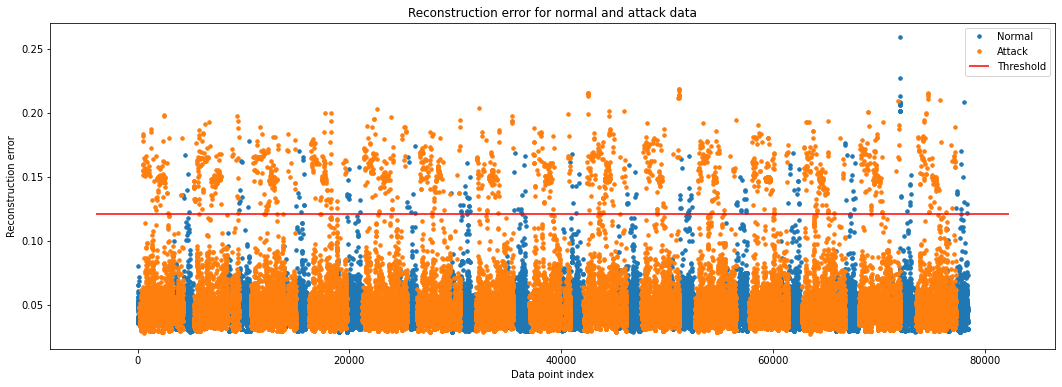

In [18]:
threshold_fixed = threshold
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

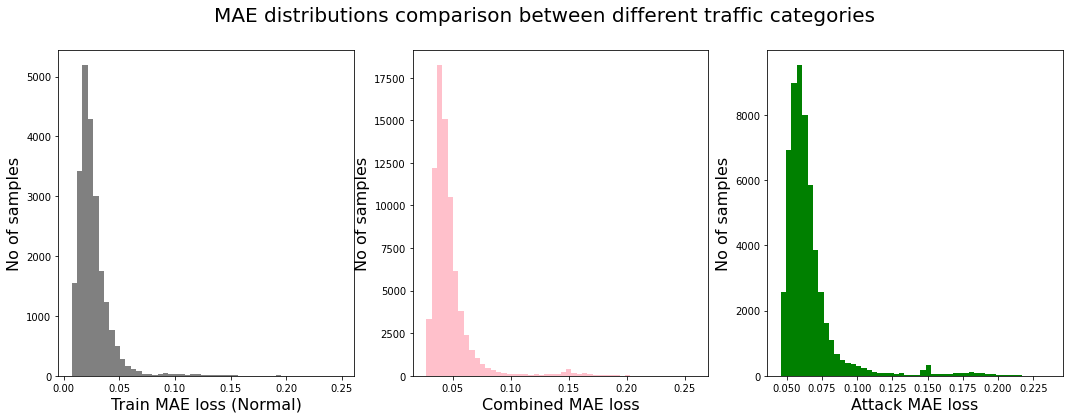

In [19]:
# comparison of MAE distributions (attack, normal and combined)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('MAE distributions comparison between different traffic categories',size=20)
ax1.hist(train_mae_loss, bins=50, color='grey')
ax1.set_xlabel('Train MAE loss (Normal)', size=16)
ax1.set_ylabel('No of samples', size = 16)
ax2.hist(test_mae_loss, bins=50, color='pink')
ax2.set_xlabel('Combined MAE loss', size = 16)
ax2.set_ylabel('No of samples', size = 16)
ax3.hist(attack_mae_loss, bins=50, color='green')
ax3.set_xlabel('Attack MAE loss', size = 16)
ax3.set_ylabel('No of samples', size = 16)
plt.show()

In [20]:
print("number of attacks", np.sum(combine_labels), 'number of normal ', 
      len(combine_labels) - np.sum(combine_labels))

number of attacks 55663 number of normal  22714


In [21]:
def accuracy_labels(a,b):
    i=0
    n = 0
    p = 0
    fp = 0
    fn = 0
    ac = 0
    for i in range (0,len(a)):
        if (a[i] == False) and(b[i] == 0): # False and 0 is normal traffic right
            n = n + 1
            ac = ac + 1
        elif (a[i] == True) and (b[i]==1): # True (attack) and 1 attack is attack right
            p = p + 1
            ac = ac + 1
        elif (a[i] == False) and (b[i] == 1): # False (normal) and 1 is false negative
            fn = fn + 1
        elif (a[i] == True) and (b[i] == 0): # True (attack) and 0 is false positive
            fp = fp + 1
        else:
            print (a[i], b[i])
    print (i, '-> elements')
    return n, p, fp, fn, ac
            

In [22]:
neg, pos, false_pos, false_neg, accuracy = accuracy_labels(anomalies, combine_labels)

78376 -> elements


In [23]:
print ('accuracy :', accuracy/len(combine_labels))
print ('negatives :', neg)
print ('positives :', pos)
print ('false negatives :', false_neg)
print ('false positives :', false_pos)

accuracy : 0.30798576112890264
negatives : 22529
positives : 1610
false negatives : 54053
false positives : 185


In [24]:
#EOF